## Customer Segmentation using K-Means Clustering

We will be using the CRISP-DM methodology for this data science project.

### Stage 1: Business Understanding
#### Problem Statement
Your client owns a large mall and has some basic data about their customers such as Customer ID, age, gender, annual income, and spending score. Youa re tasked with clustering the customers in such a way that you can provide meaningful insights that the marketing team can use in a customer marketing strategy.

#### Objectives
* Use $k$-means clustering to segment the customers
* Find the optimum number of customer clusters
* Determine target customers for the marketing strategy
* Explain how the marketing strategy works in the real world

#### Definitions of Success
* The optimum number of clusters

#### Presentation
* Dashboard
* Cloud application

#### Timelines
* 1 week

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
palette = {'Male': '#7C0000', 'Female': '#BE8080'}

from sklearn.cluster import KMeans
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import pearsonr

In [2]:
def reg_coef(x, y, label=None, color=None, **kwargs):
    ax = plt.gca()
    r,p = pearsonr(x,y)
    ax.annotate('r = {:.2f}'.format(r), xy=(0.5,0.5), xycoords='axes fraction', ha='center', color=color)

In [3]:
df = pd.read_csv('data/Mall_Customers.csv')
df

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


### Stage 2: Data Understanding
#### Data Quality
| Data Quality Issues | Treatment Options |
|---------------------|-------------------|
| Missing values | No missing values |
| Outliers | Cannot be determined prior to clustering |
| Normalised data | Data requires normalisation |
| Features | Drop `CustomerID` and convert `Gender` to categorical data type |

In [4]:
# Check for missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


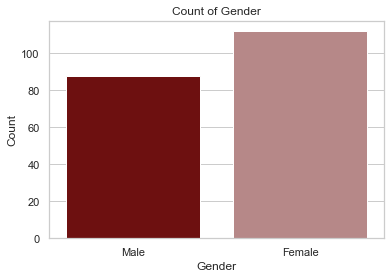

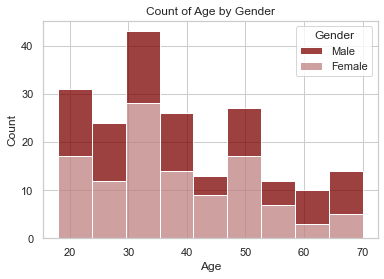

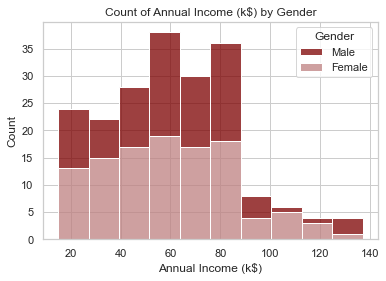

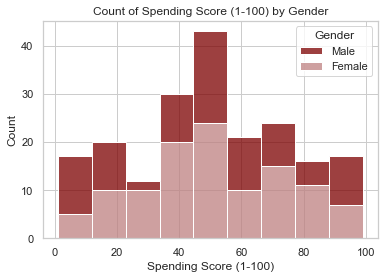

In [5]:
# Distribution plots
for var in df.columns[1:]:
    if var=='Gender':
        df_gender = pd.DataFrame(df['Gender'].value_counts()).reset_index().sort_values(by='Gender', ascending=True)
        df_gender.rename(columns={'Gender': 'Count', 'index': 'Gender'}, inplace=True)
        sns.barplot(data=df_gender, x=var, y='Count', palette=palette).set(title='Count of '+var)
    else:
        sns.histplot(data=df, x=var, hue='Gender', multiple='stack', palette=palette).set(title='Count of '+var+' by Gender')
    plt.show()

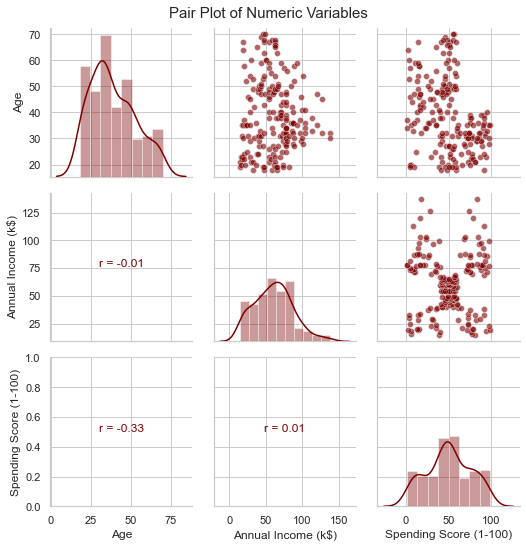

In [6]:
# Show correlations and distribution
numeric_cols = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
color = '#7C0000'

grid = sns.PairGrid(df, vars=numeric_cols)
grid.map_diag(sns.distplot, color=color)
grid.map_upper(sns.scatterplot, alpha=0.6, color=color)
grid.map_lower(reg_coef, color=color)
plt.suptitle('Pair Plot of Numeric Variables', size=15, y=1.01)
plt.show()

# sns.pairplot(df, diag_kind='kde')
# plt.show()

### Stage 3: Data Preparation
This is where we address the data quality issues from Stage 2.

In [7]:
# Drop `CustomerID` and convert `Gender` to categorical type
customer_id = df.pop('CustomerID')
# df.drop(columns={'CustomerID'}, inplace=True)
df['Gender'] = df['Gender'].astype('category')

In [8]:
# # Ensure the numeric cols are integers
# for var in numeric_cols:
#     df[var] = df[var].astype('float64')
# #     df[var] = pd.to_numeric(df[var], errors='coerce')
# df[numeric_cols].info()

In [9]:
# Normalise the data
transformer = Normalizer()
X = df[['Annual Income (k$)', 'Spending Score (1-100)']]
X_transformed = transformer.fit_transform(X)
# X_transformed.insert(loc=0, column='Gender', value=df['Gender'])
# X_transformed.rename(columns={0: 'Age', 
#                               1: 'Annual Income (k$)',
#                               2: 'Spending Score (1-100)'}, 
#                      inplace=True)
X_transformed

array([[0.35897908, 0.93334561],
       [0.18208926, 0.983282  ],
       [0.93632918, 0.35112344],
       [0.20344646, 0.97908607],
       [0.39114064, 0.92033092],
       [0.21828984, 0.97588398],
       [0.9486833 , 0.31622777],
       [0.18807227, 0.98215519],
       [0.98776297, 0.15596257],
       [0.25515426, 0.96690036],
       [0.80505584, 0.59319904],
       [0.18847945, 0.98207713],
       [0.8       , 0.6       ],
       [0.25139836, 0.9678837 ],
       [0.83844362, 0.54498835],
       [0.24542187, 0.96941637],
       [0.51449576, 0.85749293],
       [0.30320366, 0.95292578],
       [0.62139471, 0.78349768],
       [0.22848559, 0.97354729],
       [0.56552836, 0.82472885],
       [0.31232107, 0.9499766 ],
       [0.98058068, 0.19611614],
       [0.32399297, 0.94605949],
       [0.89442719, 0.4472136 ],
       [0.32314385, 0.94634986],
       [0.65850461, 0.75257669],
       [0.41716766, 0.90882955],
       [0.68315713, 0.73027141],
       [0.31622777, 0.9486833 ],
       [0.

### Stage 4: Modelling
We will be using the $k$-means clustering method for all models - the only things that need to be changed are the parameters and metrics.

#### Baseline Model
For the baseline model, we will just use the default methods and values for each item.

| Item type | Item | Method | Reason for use |
|-----------|------|--------|----------------|
| Parameter | Number of clusters ($k$) | Square root of the number of observations | Default method |
| Parameter | Initialisation method | Random | Default method |
| Parameter | Maximum iterations | 300 | Default value |
| Parameter | $k$-means algorithm to use | Lloyd | Default algorithm |
| Metric | Distance metric | Euclidean distance | Default metric |

In [10]:
# Initialise the k-means method
wcss = []
cluster_max = int(np.sqrt(X_transformed.shape[0])) + 5

for i in range(1, cluster_max):
    kmeans = KMeans(n_clusters=i,
                    init='random',
                    max_iter=300,
                    random_state=123,
                    algorithm='lloyd').fit(X_transformed)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
wcss

[269981.28,
 181363.595959596,
 106348.3730621112,
 73679.78903948834,
 44448.45544793371,
 37265.86520484346,
 30259.65720728547,
 25028.02047526941,
 22852.586090137254,
 20157.31424362459,
 18085.92329124364,
 16351.6845623255,
 14454.323519359896,
 13933.325111163345,
 12113.963779100157,
 10866.2654060773,
 10805.884453696346,
 9984.52996676526]

### Stage 5: Evaluation

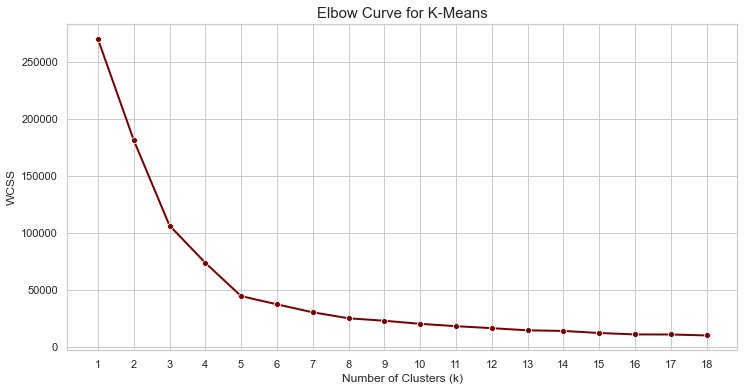

In [11]:
# Plot the elbow curve
plt.figure(figsize=(12,6))
sns.lineplot(x=range(1, cluster_max), 
             y=wcss, 
             linewidth=2, 
             color=color, 
             marker='8')
plt.xlabel('Number of Clusters (k)')
plt.xticks(np.arange(1, cluster_max, 1))
plt.ylabel('WCSS')
plt.title('Elbow Curve for K-Means', size=15)
plt.show()

In [12]:
# Fitting to the input data with k=5
kmeans1 = KMeans(n_clusters=5,
                init='random',
                max_iter=300,
                random_state=123,
                algorithm='lloyd').fit(X_transformed)
kmeans1.fit(X)

# Predict the labels of the input data
y = kmeans1.predict(X)
df['Label'] = y
df

,Gender,Age,Annual Income (k$),Spending Score (1-100),Label
0,Male,19,15,39,2
1,Male,21,15,81,1
2,Female,20,16,6,2
3,Female,23,16,77,1
4,Female,31,17,40,2
...,...,...,...,...,...
195,Female,35,120,79,0
196,Female,45,126,28,3
197,Male,32,126,74,0
198,Male,32,137,18,3


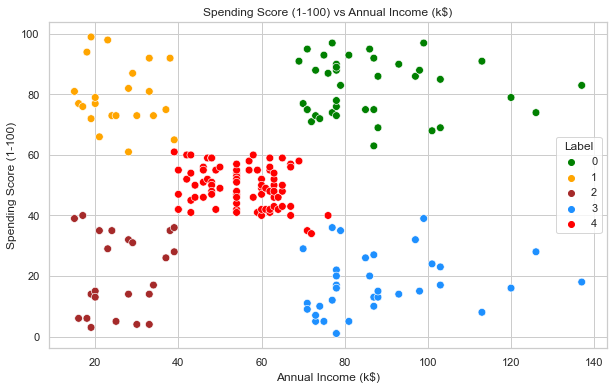

In [13]:
# Scatterplot of the clusters
plt.figure(figsize=(10,6))
sns.scatterplot(x = 'Annual Income (k$)',y = 'Spending Score (1-100)', hue="Label",  
                 palette=['green','orange','brown','dodgerblue','red'], legend='full', data=df, s=60)
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)') 
plt.title('Spending Score (1-100) vs Annual Income (k$)')
plt.show()

## 3D Data

In [14]:
# Normalise the data
transformer = Normalizer()
X = df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']]
X_transformed = transformer.fit_transform(X)
# X_transformed.insert(loc=0, column='Gender', value=df['Gender'])
# X_transformed.rename(columns={0: 'Age', 
#                               1: 'Annual Income (k$)',
#                               2: 'Spending Score (1-100)'}, 
#                      inplace=True)
X_transformed

array([[0.41392469, 0.32678265, 0.84963489],
       [0.24702464, 0.17644617, 0.95280931],
       [0.76028592, 0.60822874, 0.22808578],
       [0.28069661, 0.19526721, 0.93972343],
       [0.5806832 , 0.31843918, 0.74926865],
       [0.27185366, 0.21006874, 0.93913083],
       [0.87913063, 0.45212432, 0.15070811],
       [0.23366214, 0.18286603, 0.95496702],
       [0.95768043, 0.28431138, 0.04489127],
       [0.37368855, 0.23666942, 0.89685253],
       [0.94319433, 0.26747302, 0.19708538],
       [0.3279921 , 0.17805285, 0.92774908],
       [0.91832409, 0.31666348, 0.23749761],
       [0.28882142, 0.24068452, 0.92663539],
       [0.84047507, 0.45431085, 0.29530205],
       [0.26063351, 0.23693955, 0.93591123],
       [0.65094455, 0.39056673, 0.65094455],
       [0.27743014, 0.29130164, 0.91551945],
       [0.81469084, 0.36034402, 0.45434681],
       [0.32841056, 0.21581265, 0.91954957],
       [0.63625848, 0.43629153, 0.63625848],
       [0.30937372, 0.29699877, 0.90337126],
       [0.

In [15]:
# Initialise the k-means method
wcss = []
cluster_max = int(np.sqrt(X_transformed.shape[0])) + 5

for i in range(1, cluster_max):
    kmeans = KMeans(n_clusters=i,
                    init='random',
                    max_iter=300,
                    random_state=123,
                    algorithm='lloyd').fit(X_transformed)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
wcss

[308812.77999999997,
 212840.16982097185,
 143342.751571706,
 104366.151455562,
 82608.63809385581,
 58302.406308603684,
 51528.40617873355,
 44637.39564017064,
 41879.74661164496,
 38453.107552103625,
 35929.78018562383,
 33688.94956614642,
 30673.467492017786,
 28735.32700289906,
 26996.357905982906,
 25642.386111111115,
 24150.88418803419,
 23288.64801587302]

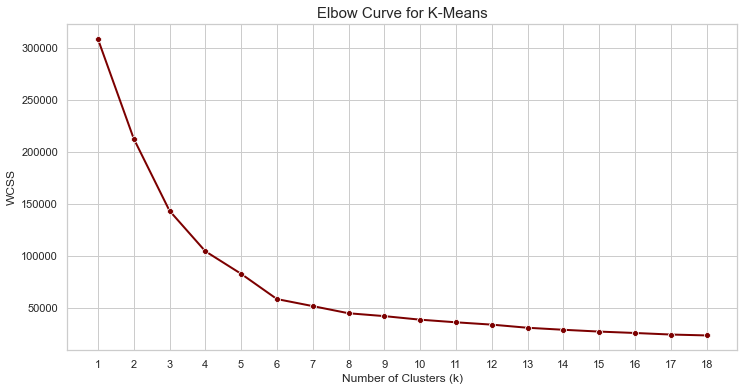

In [16]:
# Plot the elbow curve
plt.figure(figsize=(12,6))
sns.lineplot(x=range(1, cluster_max), 
             y=wcss, 
             linewidth=2, 
             color=color, 
             marker='8')
plt.xlabel('Number of Clusters (k)')
plt.xticks(np.arange(1, cluster_max, 1))
plt.ylabel('WCSS')
plt.title('Elbow Curve for K-Means', size=15)
plt.show()

In [20]:
# Fitting to the input data with k=6
kmeans2 = KMeans(n_clusters=6,
                init='random',
                max_iter=300,
                random_state=123,
                algorithm='lloyd').fit(X_transformed)
kmeans2.fit(X)

# Predict the labels of the input data
y = kmeans2.predict(X)
df2 = df.copy()
df2['label'] = y
df2['CustomerID'] = customer_id
df2

,Gender,Age,Annual Income (k$),Spending Score (1-100),Label,label,CustomerID
0,Male,19,15,39,2,2,1
1,Male,21,15,81,1,1,2
2,Female,20,16,6,2,2,3
3,Female,23,16,77,1,1,4
4,Female,31,17,40,2,2,5
...,...,...,...,...,...,...,...
195,Female,35,120,79,0,4,196
196,Female,45,126,28,3,3,197
197,Male,32,126,74,0,4,198
198,Male,32,137,18,3,3,199


No handles with labels found to put in legend.


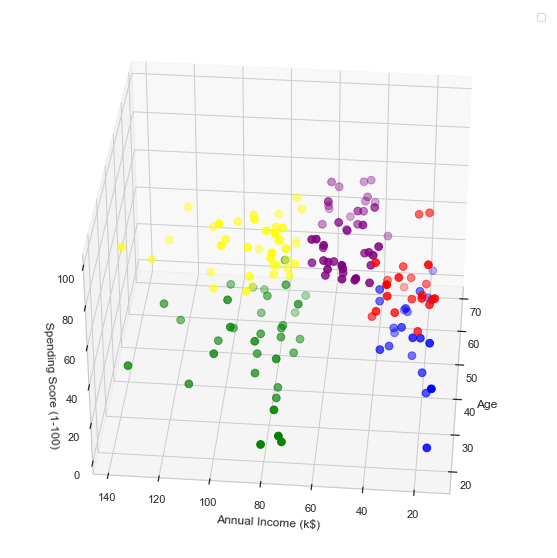

In [26]:
# 3D Scatterplot of the clusters
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df2.Age[df2.label == 0], df2["Annual Income (k$)"][df2.label == 0], df2["Spending Score (1-100)"][df2.label == 0], c='purple', s=60)
ax.scatter(df2.Age[df2.label == 1], df2["Annual Income (k$)"][df2.label == 1], df2["Spending Score (1-100)"][df2.label == 1], c='red', s=60)
ax.scatter(df2.Age[df2.label == 2], df2["Annual Income (k$)"][df2.label == 2], df2["Spending Score (1-100)"][df2.label == 2], c='blue', s=60)
ax.scatter(df2.Age[df2.label == 3], df2["Annual Income (k$)"][df2.label == 3], df2["Spending Score (1-100)"][df2.label == 3], c='green', s=60)
ax.scatter(df2.Age[df2.label == 4], df2["Annual Income (k$)"][df2.label == 4], df2["Spending Score (1-100)"][df2.label == 4], c='yellow', s=60)
ax.view_init(35, 185)
plt.xlabel("Age")
plt.ylabel("Annual Income (k$)")
ax.set_zlabel('Spending Score (1-100)')
plt.show()

In [25]:
# Get Customer IDs
cust1=df2[df2["label"]==0]
print('Number of customer in 1st group=', len(cust1))
print('They are -', cust1["CustomerID"].values)
print("--------------------------------------------")
cust2=df2[df2["label"]==1]
print('Number of customer in 2nd group=', len(cust2))
print('They are -', cust2["CustomerID"].values)
print("--------------------------------------------")
cust3=df2[df2["label"]==2]
print('Number of customer in 3rd group=', len(cust3))
print('They are -', cust3["CustomerID"].values)
print("--------------------------------------------")
cust4=df2[df2["label"]==3]
print('Number of customer in 4th group=', len(cust4))
print('They are -', cust4["CustomerID"].values)
print("--------------------------------------------")
cust5=df2[df2["label"]==4]
print('Number of customer in 5th group=', len(cust5))
print('They are -', cust5["CustomerID"].values)
print("--------------------------------------------")
cust6=df2[df2["label"]==5]
print('Number of customer in 6th group=', len(cust6))
print('They are -', cust6["CustomerID"].values)
print("--------------------------------------------")

Number of customer in 1st group= 44
They are - [ 41  47  51  54  55  56  57  58  60  61  63  64  65  67  68  71  72  73
  74  75  77  80  81  83  84  86  87  90  91  93  97  99 102 103 105 107
 108 109 110 111 117 118 119 120]
--------------------------------------------
Number of customer in 2nd group= 22
They are - [ 2  4  6  8 10 12 14 16 18 20 22 24 26 28 30 32 34 36 38 40 42 46]
--------------------------------------------
Number of customer in 3rd group= 22
They are - [ 1  3  5  7  9 11 13 15 17 19 21 23 25 27 29 31 33 35 37 39 43 45]
--------------------------------------------
Number of customer in 4th group= 35
They are - [127 129 131 135 137 139 141 145 147 149 151 153 155 157 159 161 163 165
 167 169 171 173 175 177 179 181 183 185 187 189 191 193 195 197 199]
--------------------------------------------
Number of customer in 5th group= 39
They are - [124 126 128 130 132 134 136 138 140 142 144 146 148 150 152 154 156 158
 160 162 164 166 168 170 172 174 176 178 180 182 184 